# Imports

In [181]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sci

# Definitions

In [182]:
class Parabolic:
    def __init__(self, N, case, x, u0, a_type, b_type):
        self.N = N
        self.case = case
        self.x = x
        self.u0 = u0
        self.a_type = a_type
        self.b_type = b_type


    def cd(self, x):
        if self.case == 0 or self.case == 1 or self.case == 4:
            return 1
        if self.case == 2:
            return x
        if self.case == 3:
            return x ** 2

    def f(self, x, u):
        if self.case == 4:
            return u
        else:
            return 0

    def u_a(self, case):
        if self.case == 0:
            return 1
        return 0
    
    def u_b(self, case):
        if self.case == 4:
            return 0
        return 1


In [183]:
### Number of intervals in mesh
N = 30

### p(x) for defining intervals
def p(x):
    return x + 0.9 * x * (1 - x)

### x[i]
x = np.zeros(N + 1)
for i in range(N + 1):
    x[i] = p(i / N)

### dt
def dt(case):
    if case == 0 or case == 4:
        return 0.05
    else:
        return 0.01

# Residual

In [184]:
def resid(U, dU, t, case, para):
    W = U + dU
    res = np.zeros(N + 1)
    for i in range(0, N):
        problem = Parabolic
        xmid = (x[i] + x[i+1]) / 2
        dx = x[i+1] - x[i]
        res[i] += problem.cd(para, xmid) * dx/dt(case) * (1/3 * dU[i] + 1/6 * dU[i+1]) + problem.cd(para, xmid) / dx * (W[i] - W[i+1]) - problem.f(para, xmid, t + dt(case)) * dx/2
        res[i+1] += problem.cd(para, xmid) * dx/dt(case) * (1/6 * dU[i] + 1/3 * dU[i+1]) + problem.cd(para, xmid) / dx * (W[i+1] - W[i]) - problem.f(para, xmid, t + dt(case)) * dx/2

    ## Boundary conditions
    if para.a_type == "D":
        res[0] = W[0] - para.u_a(case)
    if para.a_type == "N":
        res[0] -= para.u_a(case)
    if para.b_type == "D":
        res[-1] = W[-1] - para.u_b(case)
    if para.b_type == "N":
        res[-1] += para.u_b(case)

    
    return res

# Construction of C

In [185]:
def c(U, t, case, para):
    Cdata = np.zeros((3, N+1))
    dU = np.zeros(N+1)
    Rbase = resid(U, dU, t, case, para)
    epsilon = 1 * (10 ** (-6))
    for k in range(3):
        dU = np.zeros(N+1)
        for i in range(k, N+1, 3):
            dU[i] += epsilon
        R = (resid(U, dU, t, case, para) - Rbase) / epsilon
        for i in range(k, N+1, 3):
            Cdata[0][i] = R[i-1]
            Cdata[1][i] = R[i]
            if i == N:
                break
            Cdata[2][i] = R[i+1]
        Cdata[0][0] = 0
    return Cdata

# Iterating

In [179]:
def step(start, stop, case, para):
    U = para.u0
    t = start
    zeros = np.zeros(N+1)
    ut0 = np.zeros(int((stop-start)/dt(case)))
    count = 0
    while t < stop:
        r = resid(U, zeros, t, case, para)
        C = c(U, t, case, para)
        ut0[count] = U[0]
        dU = sci.solve_banded((1,1), C, -r)
        U += dU
        t += dt(case)
        count += 1
    return (U, ut0)

# Case 0

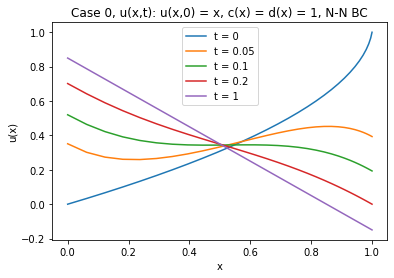

In [186]:
### Case 0

u0 = np.zeros(N+1)
for i in range(N+1):
    u0[i] = i/N

problem0 = Parabolic(N, 0, x, u0, "N", "N")

fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title('Case 0, u(x,t): u(x,0) = x, c(x) = d(x) = 1, N-N BC')
ax.plot(x, step(0, 0, 0, problem0)[0], label='t = 0')
ax.plot(x, step(0, 0.05, 0, problem0)[0], label='t = 0.05')
ax.plot(x, step(0.05, 0.1, 0, problem0)[0], label='t = 0.1')
ax.plot(x, step(0.1, 0.2, 0, problem0)[0], label='t = 0.2')
ax.plot(x, step(0.2, 1, 0, problem0)[0], label='t = 1')
ax.legend()

# Case 1

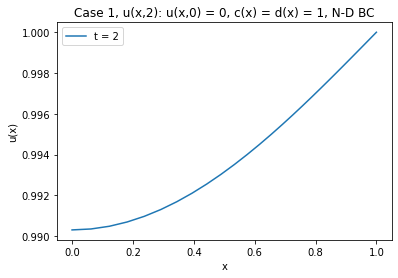

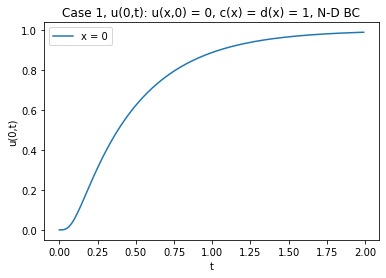

In [187]:
### Case 1

u1 = np.zeros(N+1)
x1 = np.arange(0, 2, dt(1))

problem1 = Parabolic(N, 1, x, u1, "N", "D")

u1 = step(0, 2, 1, problem1)
u1_0 = u1[1]
u1_2 = u1[0]

fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title('Case 1, u(x,2): u(x,0) = 0, c(x) = d(x) = 1, N-D BC')
ax.plot(x, u1_2, label='t = 2')
ax.legend()

fig, ax = plt.subplots()
ax.set_xlabel('t')
ax.set_ylabel('u(0,t)')
ax.set_title('Case 1, u(0,t): u(x,0) = 0, c(x) = d(x) = 1, N-D BC')
ax.plot(x1, u1_0, label='x = 0')
ax.legend()

# Case 2

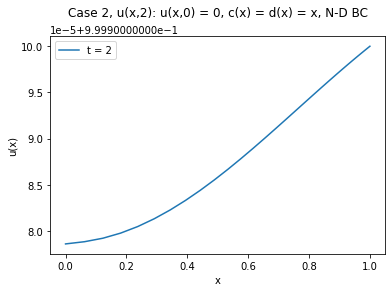

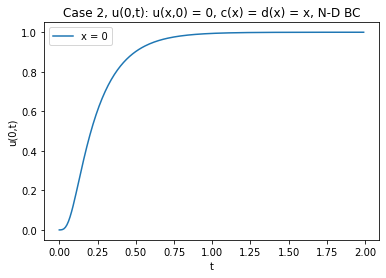

In [189]:
### Case 2

u2 = np.zeros(N+1)
x2 = np.arange(0, 2, dt(1))

problem2 = Parabolic(N, 2, x, u2, "N", "D")

u2 = step(0, 2, 2, problem2)
u2_0 = u2[1]
u2_2 = u2[0]


fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title('Case 2, u(x,2): u(x,0) = 0, c(x) = d(x) = x, N-D BC', pad=20)
ax.plot(x, u2_2, label='t = 2')
ax.legend()

fig, ax = plt.subplots()
ax.set_xlabel('t')
ax.set_ylabel('u(0,t)')
ax.set_title('Case 2, u(0,t): u(x,0) = 0, c(x) = d(x) = x, N-D BC')
ax.plot(x2, u2_0, label='x = 0')
ax.legend()

# Case 3

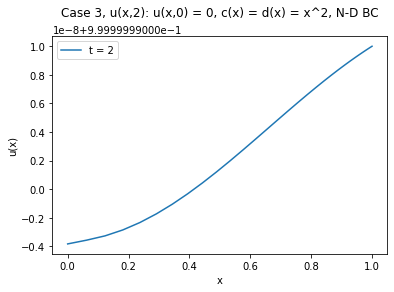

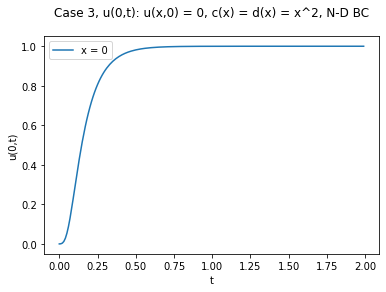

In [190]:
### Case 3

u3 = np.zeros(N+1)
x3 = np.arange(0, 2, dt(1))

problem3 = Parabolic(N, 3, x, u3, "N", "D")

u3 = step(0, 2, 3, problem3)
u3_0 = u3[1]
u3_2 = u3[0]


fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title('Case 3, u(x,2): u(x,0) = 0, c(x) = d(x) = x^2, N-D BC', pad=20)
ax.plot(x, u3_2, label='t = 2')
ax.legend()

fig, ax = plt.subplots()
ax.set_xlabel('t')
ax.set_ylabel('u(0,t)')
ax.set_title('Case 3, u(0,t): u(x,0) = 0, c(x) = d(x) = x^2, N-D BC', pad = 20)
ax.plot(x3, u3_0, label='x = 0')
ax.legend()

# Case 4

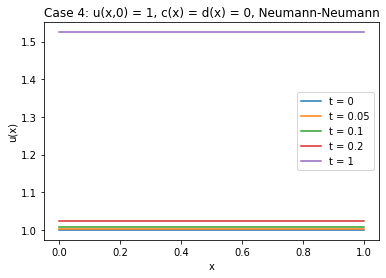

In [191]:
### Case 4

u4 = np.ones(N+1)

problem4 = Parabolic(N, 4, x, u4, "N", "N")

fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title('Case 4: u(x,0) = 1, c(x) = d(x) = 0, Neumann-Neumann')
ax.plot(x, step(0, 0, 0, problem4)[0], label='t = 0')
ax.plot(x, step(0, 0.05, 0, problem4)[0], label='t = 0.05')
ax.plot(x, step(0.05, 0.1, 0, problem4)[0], label='t = 0.1')
ax.plot(x, step(0.1, 0.2, 0, problem4)[0], label='t = 0.2')
ax.plot(x, step(0.2, 1, 0, problem4)[0], label='t = 1')
ax.legend()